In [221]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from p6_rotations import topology_to_list
from p9_sp_clusters_data import *
from joblib import dump, load


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Data Preprocessing


In [249]:
#importing data frames
all_csv = pd.read_csv('all.csv').drop(['Unnamed: 0','all_corners_comb','all_edges_comb','no_edges_comb','no_corners_comb','all_comb'],axis=1)
df = pd.DataFrame(data=list_of_sp_clusters, columns = ['full_notation','energy','SCF_steps','magnetism','time_of_calculation'])
benchmark = pd.read_csv('benchmark_ds.csv').drop(['index','Unnamed: 7'],axis=1)

#creating full notation column in benchmark
benchmark['full_notation'] = benchmark['energy']
for cluster in range(len(benchmark)):
    benchmark['full_notation'].iloc[cluster] = str(benchmark['no_cluster'].iloc[cluster]) + '_'+benchmark['joining_type'].iloc[cluster]+'_'+benchmark['rotation'].iloc[cluster]

#creating new columns in df:
for column in ['no_nickel','number','joining_type','first_atom','second_atom','topology','c_atom','mass_center','shortest_paths','conformation','bonds']:
    df[column] = df['magnetism'] 

#gathering data from full notation columns
for cluster in range(len(df)):
    df['number'].iloc[cluster] = df['full_notation'].iloc[cluster].split('_')[0] 
    df['joining_type'].iloc[cluster] = df['full_notation'].iloc[cluster].split('_')[1]
    df['first_atom'].iloc[cluster] = int(df['full_notation'].iloc[cluster].split('_')[2])
    df['second_atom'].iloc[cluster] = int(df['full_notation'].iloc[cluster].split('_')[3])
    df['energy'].iloc[cluster] = float(df['energy'].iloc[cluster][1:])

#splitting shortest paths, conformation and bonds
for column in ['ni_ncentre','ni_centre','cu_ncentre','cu_centre','0ni','8ni','17ni','25ni','33ni','42ni','50ni', 'nini','cucu','nicu','type_of_first_atom','type_of_second_atom', 'hydrogen']:
    df[column] = df['magnetism']    

#gathering data from all.csv file and splitting shortest paths, conformation and bonds
for cluster in range(len(df)):
    for column in ['no_nickel','c_atom','mass_center','shortest_paths','conformation','bonds']:
        df[column].iloc[cluster] = all_csv[column].loc[int(df['number'].iloc[cluster])]
    for column in ['topology']:
        df[column].iloc[cluster] = topology_to_list(all_csv[column].loc[int(df['number'].iloc[cluster])])
    df['ni_ncentre'].iloc[cluster] = int(str(df['shortest_paths'].iloc[cluster].split(',')[0])[1:])
    df['ni_centre'].iloc[cluster] = int(df['shortest_paths'].iloc[cluster].split(',')[1])
    df['cu_ncentre'].iloc[cluster] = int(df['shortest_paths'].iloc[cluster].split(',')[2])
    df['cu_centre'].iloc[cluster] = int(str(df['shortest_paths'].iloc[cluster].split(',')[3])[:-1])
    df['0ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[0])[1:])
    df['50ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[6])[:-1])
    df['8ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[1]))
    df['17ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[2]))
    df['25ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[3]))
    df['33ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[4]))
    df['42ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[5]))
    df['nini'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[0])[1:])
    df['cucu'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[2])[:-1])
    df['nicu'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[1]))
    df['type_of_first_atom'].iloc[cluster] = df['topology'].iloc[cluster][df['first_atom'].iloc[cluster]]
    df['type_of_second_atom'].iloc[cluster] = df['topology'].iloc[cluster][df['second_atom'].iloc[cluster]]
    if df['joining_type'].iloc[cluster] in ['MOCOM','MOCM_H_n_bond']:
        df['hydrogen'].iloc[cluster] = 1
    else:
        df['hydrogen'].iloc[cluster] = 0

#df = df[(df['joining_type']=='MOCMHnbond') | (df['joining_type']=='MOCOM') | (df['joining_type']=='MOCM')]
#df = df[df['no_nickel'] <12]
#df = df[df['no_nickel'] >2]
print('len:', len(df))
print(df['joining_type'].unique())
print(df['no_nickel'].unique())

full_dataset = df


C:\Users\stott\AppData\Local\Temp\ipykernel_14456\4048210439.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark['full_notation'].iloc[cluster] = str(benchmark['no_cluster'].iloc[cluster]) + '_'+benchmark['joining_type'].iloc[cluster]+'_'+benchmark['rotation'].iloc[cluster]


len: 578
['MO' 'MOCOM' 'MC' 'MOCMHnbond' 'MOCM']
[6 5 4 7 3 1 2]


## Functions to create ML model

In [239]:
def ada(X_train,X_test,y_train,y_test, estimators= [50,100,150,200,250,300], lr = [0.2,0.4,0.6,0.8,1,1.5,2,3]):
    
    best_acc = [0]
    for est in estimators:
        for learning_rate in lr:  
        
            model = AdaBoostRegressor(n_estimators=est, learning_rate=learning_rate)    
            model.fit(X_train, y_train)
            model_pred = model.predict(X_test)

            srednia_error = 0    

            for i in range(len(model_pred)):
                srednia_error+= np.sqrt((model_pred[i]-y_test[i])**2)            
            srednia_error /= len(model_pred)   

            acc = 1-(srednia_error/(max(y_test)-min(y_test)))   
            
            if acc > best_acc[0]:
                best_acc = [acc, 'ada',  'est:',est, 'learning rate:',learning_rate]
                dump(model, 'model_ada.joblib') 

            
            print('acc:',acc, 'type of alg: ada', 'est:', est, 'learning rate:', learning_rate)       
    return(best_acc, y_test, model_pred)

def rf(X_train,X_test,y_train,y_test, estimators= [50,100,150,200,250,300]):
    
    best_acc = [0]
    for est in estimators:

        model = RandomForestRegressor(n_estimators=est)  
        
        model.fit(X_train, y_train)
        model_pred = model.predict(X_test)

        srednia_error = 0    
        for i in range(len(model_pred)):
            srednia_error+= np.sqrt((model_pred[i]-y_test[i])**2)            
        srednia_error /= len(model_pred)   

        acc = 1-(srednia_error/(max(y_test)-min(y_test)))   

        if acc > best_acc[0]:
            best_acc = [acc, 'rf', 'est:' , est,]
            dump(model, 'model_rf.joblib') 
        
        print('acc:',acc, 'type of alg:', 'rf', 'est:', est)   
    
    return(best_acc, y_test, model_pred)

def brf(X_train,X_test,y_train,y_test, estimators= [50,100,150,200,250,300], lr = [0.2,0.4,0.6,0.8,1,1.5,2,3], md = [1,2,3]):
    
    best_acc = [0]
    for est in estimators:
        for learning_rate in lr:
            for max_depth in md:
    
                model = GradientBoostingRegressor(n_estimators=est, learning_rate=learning_rate, max_depth=max_depth)  

                model.fit(X_train, y_train)
                model_pred = model.predict(X_test)

                srednia_error = 0    

                for i in range(len(model_pred)):
                    srednia_error+= np.sqrt((model_pred[i]-y_test[i])**2)            
                srednia_error /= len(model_pred)   

                acc = 1-(srednia_error/(max(y_test)-min(y_test)))   

                if acc > best_acc[0]:
                    best_acc = [acc, 'brf', 'est:' ,est, 'learning rate:', learning_rate, 'max_depth:',max_depth]
                    dump(model, 'model_brf.joblib') 
                print('acc:',acc, 'type of alg:', 'brf', 'est:', est, 'learning rate:', learning_rate, 'max depth:', max_depth)    

    return(best_acc, y_test, model_pred)

def svr(X_train,X_test,y_train,y_test, C_parameter = [0.2,0.4,0.6,0.8,1,1.5,2,3], degrees = [x for x in range(1,8)]):
    
    best_acc = [0]
    for C in C_parameter:
        for degree in degrees:
            
                model = SVR(C=C,degree = degree)
                model.fit(X_train, y_train)
                model_pred = model.predict(X_test)

                srednia_error = 0    

                for i in range(len(model_pred)):
                    srednia_error+= np.sqrt((model_pred[i]-y_test[i])**2)            
                srednia_error /= len(model_pred)   

                acc = 1-(srednia_error/(max(y_test)-min(y_test)))   

                if acc > best_acc[0]:
                    best_acc = [acc, 'svr', 'C: ', C,'degree:', degree]
                    dump(model, 'model_svr.joblib') 
                print('acc:',acc, 'type of alg:' 'C:', C, 'degree:', degree)   
    
    return(best_acc, y_test, model_pred)

def printing(model, y_test, nn=False):  
    frame = []

    if nn == True:
        for char in range(len(model)):
            preframe = []
            preframe.append(model[char][0])
            preframe.append(y_test[char])
            frame.append(preframe)  
    else:
        for char in range(len(model)):
            preframe = []
            preframe.append(model[char])
            preframe.append(y_test[char])
            frame.append(preframe) 
    frame = pd.DataFrame(data=frame, columns =['y_test','model_pred'])   
    frame = frame.sort_values(by=['y_test']).reset_index(drop=True)
    sns.scatterplot(data=frame)    
    #return frame

def data_scaling(data):
    X = data.drop(['energy','first_atom','second_atom','SCF_steps','magnetism','time_of_calculation','number','bonds','conformation','shortest_paths','full_notation','joining_type','topology'],axis=1)
    X = pd.get_dummies(data = X, columns = ['type_of_first_atom','type_of_second_atom'], drop_first=True)
    y = np.asarray(data['energy']).astype('float32')
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    X = pd.DataFrame(data=X)
    return X,y

def create_model(X, activation, n):
    
    model = Sequential()
    model.add(Dense(units=len(X.columns), activation=activation, input_dim=len(X.columns)))
    for layer in range(1,n):
            model.add(Dense(units=4*2**layer, activation='relu'))
    model.add(Dense(units=1, activation=activation))
    model.compile(loss='mse', optimizer='rmsprop')
    return model

def nn(X_train,X_test,y_train,y_test, layer = [2,3,4,5], batchs = [8,16,32,64]):    
    best_acc = [0]
    for activation in ['relu','linear']:
        for n in layer:
            for batch in batchs:
                early_stop = EarlyStopping(monitor='loss', mode='min', patience=15, restore_best_weights = True)
                model = create_model(X_train,activation,n)
                model.fit(X_train, y_train, epochs=300, batch_size=batch, callbacks=[early_stop], verbose = 0)
                model_pred = model.predict(X_test) 
                srednia_error = 0    

                for i in range(len(model_pred)):
                    srednia_error+= np.sqrt((model_pred[i][0]-y_test[i])**2)            
                srednia_error /= len(model_pred)   

                acc = 1-(srednia_error/(max(y_test)-min(y_test)))   
                print('acc:',acc, 'act:', activation, 'number_of_layers:', n, 'batch: ', batch)
                if acc > best_acc[0]:
                    best_acc = [acc, activation, n, batch]
                    model.save('model_nn.h5') 
    print(best_acc)
    return best_acc
    

## Training ML model

In [254]:
partial_dataset = full_dataset[(full_dataset['joining_type']=='MOCOM') | (full_dataset['joining_type']=='MO')]
partial_dataset = partial_dataset[partial_dataset['no_nickel'] <12]
partial_dataset = partial_dataset[partial_dataset['no_nickel'] >2]
ml_alg = ['ada','rf','brf','svr']
print('len:', len(partial_dataset))
print(partial_dataset['joining_type'].unique())
print(partial_dataset['no_nickel'].unique())

best_acc = [0]
X = data_scaling(partial_dataset)[0]
y = data_scaling(partial_dataset)[1]    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

best_ada = ada(X_train,X_test,y_train,y_test)
best_rf = rf(X_train,X_test,y_train,y_test)
best_brf = brf(X_train,X_test,y_train,y_test)
best_svr = svr(X_train,X_test,y_train,y_test)
#best_nn = nn(X_train,X_test,y_train,y_test)

for alg in [best_ada,best_rf,best_brf,best_svr]:
    try:
        print(alg[0])
    except:
        continue
try:
    print(best_nn)
except:
    pass




len: 397
['MO' 'MOCOM']
[6 5 4 7 3]
acc: 0.9696857144852483 type of alg: ada est: 50 learning rate: 0.2
acc: 0.9713917899458739 type of alg: ada est: 50 learning rate: 0.4
acc: 0.9711573765251376 type of alg: ada est: 50 learning rate: 0.6
acc: 0.9737633949487705 type of alg: ada est: 50 learning rate: 0.8
acc: 0.9712948962929908 type of alg: ada est: 50 learning rate: 1
acc: 0.9727159568145174 type of alg: ada est: 50 learning rate: 1.5
acc: 0.9771175861060029 type of alg: ada est: 50 learning rate: 2
acc: 0.9802440127689952 type of alg: ada est: 50 learning rate: 3
acc: 0.970690939120024 type of alg: ada est: 100 learning rate: 0.2
acc: 0.9711659378755795 type of alg: ada est: 100 learning rate: 0.4
acc: 0.9699787963333603 type of alg: ada est: 100 learning rate: 0.6
acc: 0.9723610465855047 type of alg: ada est: 100 learning rate: 0.8
acc: 0.9711423659222923 type of alg: ada est: 100 learning rate: 1
acc: 0.9725097220836736 type of alg: ada est: 100 learning rate: 1.5
acc: 0.97576061

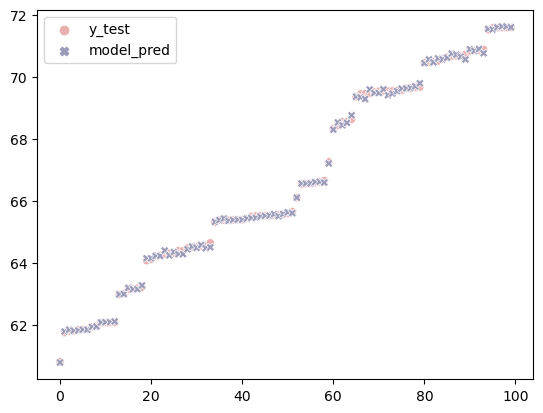

In [255]:
#ml printing
model = load('model_brf.joblib')
model_pred = model.predict(X_test)
printing(model_pred,y_test)


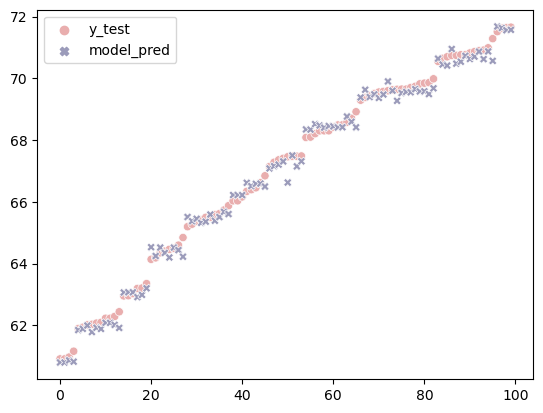

In [246]:
#nn printing
model = load_model('model_trained_by.h5')
model_pred = model.predict(X_test)
printing(model_pred,y_test, nn=True)

## Drawing Aproximate Accuracy Plot

In [12]:
sp_on_benchmark_cases = pd.DataFrame(data=sp_on_benchmark_cases, columns = ['full_notation','aproximate_energy','SCF_steps','magnetism','time'])
for char in range(len(sp_on_benchmark_cases)):
    sp_on_benchmark_cases['aproximate_energy'].iloc[char] = float(sp_on_benchmark_cases['aproximate_energy'].iloc[char])
benchmark_merge = benchmark.merge(sp_on_benchmark_cases, left_on='full_notation', right_on='full_notation')
benchmark_merge = benchmark_merge[['energy','aproximate_energy']].sort_values(by=['energy']).reset_index(drop=True)

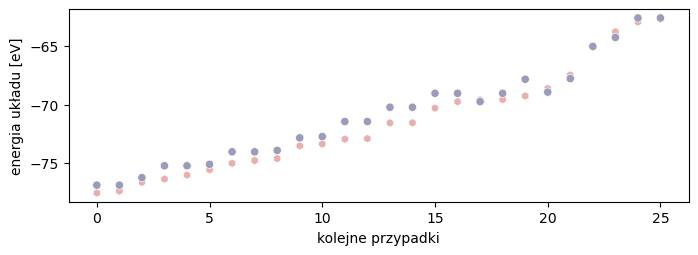

In [70]:

colors = ['#e9aeae','#9b9bba']

sns.set_palette(sns.color_palette(colors))
markers = {"energy": "h", "aproximate_energy": "o"}
plt.figure(figsize=(8,2.5))
ax = sns.scatterplot(data = benchmark_merge, markers=markers, legend= False )
ax.set_xlabel("kolejne przypadki")
ax.set_ylabel("energia układu [eV]")


f = plt.savefig('aproximate_accuracy.png')

In [35]:
max(benchmark_merge['energy'])-min(benchmark_merge['energy'])

14.887997999999996

In [220]:
results = ([best_ada[0],best_rf[0],best_brf[0],best_svr[0], best_nn])

for res in results:
    print(res)


[0.8956354501510745, 'ada', 'est:', 300, 'learning rate:', 0.6]
[0.8880759293023792, 'rf', 'est:', 200]
[0.9022359297041302, 'brf', 'est:', 100, 'learning rate:', 0.2, 'max_depth:', 1]
[0.8777301621508617, 'svr', 'C: ', 0.8, 'degree:', 1]
[0.8667930520739261, 'linear', 2, 16]


In [251]:
len(full_dataset['mass_center'].unique())

127

0      0.04345
1      0.04345
2      0.03448
3      0.03448
4      0.03448
        ...   
573    0.03253
574    0.02051
575    0.02423
576    0.02426
577    0.02812
Name: mass_center, Length: 578, dtype: object